In [1]:
# recall df
%store -r w_df
%store -r w_test
%store -r w_train
%store -r w_train_seas_diff


## PACKAGES

In [2]:
import numpy as np
import pandas as pd
import math
import statistics
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns


# for pattern identification 
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy import signal

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

## TRAIN/TEST

First we want to split the data in train and test take in consideration only the variable that we want to predict 
(in the past train/test division we define the period of time that we have in the requirment, but we have all the variables)

In [3]:
feature='T (degC)'

# TRAIN/TEST division 

train_t=w_train[feature]
test_t=w_test[feature]

In [4]:
# for take track of the accuracy of the models
accuracy_df = pd.DataFrame(columns=['Model','AIC','RMSE','MAE'])
display(accuracy_df)

,Model,AIC,RMSE,MAE


## Simple exponential smoothing

The simplest of the exponentially smoothing methods is called simple exponential smoothing (SES), also referred to as single exponential smoothing. **This method is suitable for forecasting data with no clear trend or seasonal pattern.**
When using the naïve method, all forecasts for the future are equal to the last observed value.

Forecasts are calculated using weighted averages, where the weights decrease exponentially as observations are distant in the past (i.e, the smallest weights are associated with the oldest observations).
Exponential smoothing methods are generally expressed in the component form, with one forecast equation and one smoothing equation per component.


In our case we have a strong seasonal component so in order to obtain better result could be better to use **DESEASONAL VALUE**

### 1_s) SAS - SEASONAL TRAIN 

,Param Name,Values
0,smoothing_level,0.716936
1,initial_level,-5.404262


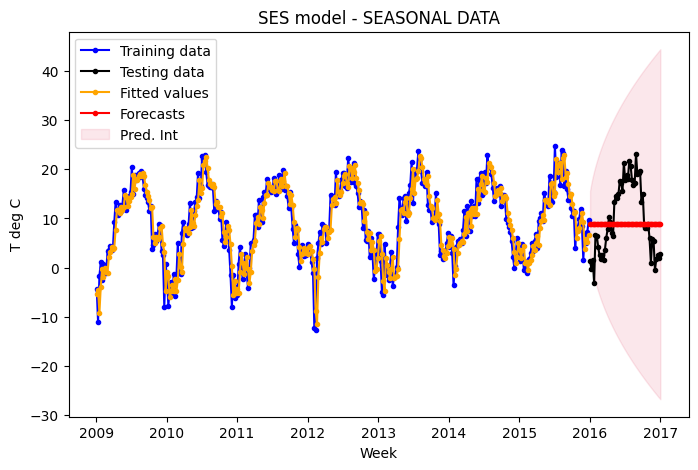

In [5]:
# we start appling it with the seasonal data
model_sta_SES = ETSModel(train_t, error = 'add').fit()

# parameters
par_table_sta = {'Param Name': model_sta_SES.param_names, 'Values': model_sta_SES.params}
par_table_sta = pd.DataFrame(par_table_sta)
display(par_table_sta)

# prediction
pred_model_sta_SES=model_sta_SES.get_prediction(start=test_t.index[0],end=test_t.index[-1])
# summary
summary_sta_SESmodel_df=pred_model_sta_SES.summary_frame()
#forecast
forecast_sta=summary_sta_SESmodel_df['mean']

# PLOT
plt.figure(figsize=(8,5))
plt.plot(train_t, color='blue',marker = '.',label='Training data')
plt.plot(test_t, color='black', marker = '.',label='Testing data')
plt.plot(model_sta_SES.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecast_sta, color='red', marker = '.', label='Forecasts')
plt.fill_between(summary_sta_SESmodel_df.index, summary_sta_SESmodel_df['pi_lower'], summary_sta_SESmodel_df['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('T deg C')
plt.title('SES model - SEASONAL DATA')
plt.legend()
plt.show()

In [6]:
model_sta_SES.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               T (degC)   No. Observations:                  365
Model:                       ETS(ANN)   Log Likelihood                -969.719
Date:                Wed, 29 Jan 2025   AIC                           1945.439
Time:                        15:55:29   BIC                           1957.139
Sample:                    01-04-2009   HQIC                          1950.089
                         - 12-27-2015   Scale                           11.889
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.7169      0.054     13.388      0.000       0.612       0.822
initial_level      -5.4043      3.308     -1.634      0.102     -11.887       1.078
===================================================================================
Ljung-Box (Q):                        4.52   Jarque-Bera (JB):                10.44
Prob(Q):                              0.10   Prob(JB):                         0.01
Heteroskedasticity (H):               0.83   Skew:                             0.08
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [7]:
# ACCURACY SES MODEL

accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'Model':'SES_seasonal', 'AIC':model_sta_SES.aic, 'RMSE':root_mean_squared_error(test_t, summary_sta_SESmodel_df['mean']), 'MAE':mean_absolute_error(test_t, summary_sta_SESmodel_df['mean'])},index=[0])], ignore_index=True)

C:\Users\lovoa\AppData\Local\Temp\ipykernel_21404\1770646506.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'Model':'SES_seasonal', 'AIC':model_sta_SES.aic, 'RMSE':root_mean_squared_error(test_t, summary_sta_SESmodel_df['mean']), 'MAE':mean_absolute_error(test_t, summary_sta_SESmodel_df['mean'])},index=[0])], ignore_index=True)


### DESEASONAL TRAIN 

In [8]:
# Deseasonal one
w_train_seas_diff.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 313 entries, 2010-01-03 to 2015-12-27
Freq: W-SUN
Series name: T (degC)
Non-Null Count  Dtype  
--------------  -----  
313 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


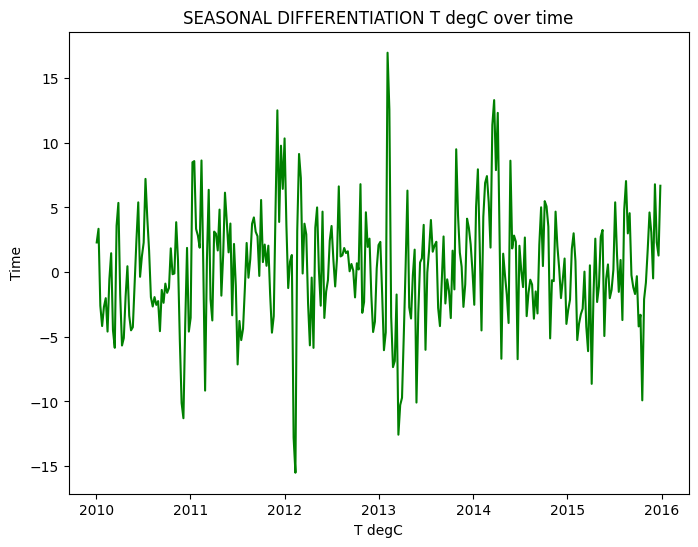

In [9]:
# first i want to remove null values
w_train_seas_diff.dropna(inplace=True)

# PLOT
plt.figure(figsize=(8,6))
plt.plot(w_train_seas_diff,color='Green')
plt.xlabel('T degC')
plt.ylabel('Time')
plt.title('SEASONAL DIFFERENTIATION T degC over time')
plt.show()

In [10]:
# TRAIN/TEST --> DESEASONAL DATA
 
#feature='T (degC)'

# TRAIN/TEST division 
des_train_t=w_train_seas_diff[w_train_seas_diff.index < '2016-01-01']


### 1_d) SES - with deseasonal train 


,Param Name,Values
0,smoothing_level,0.114677
1,initial_level,-0.958494


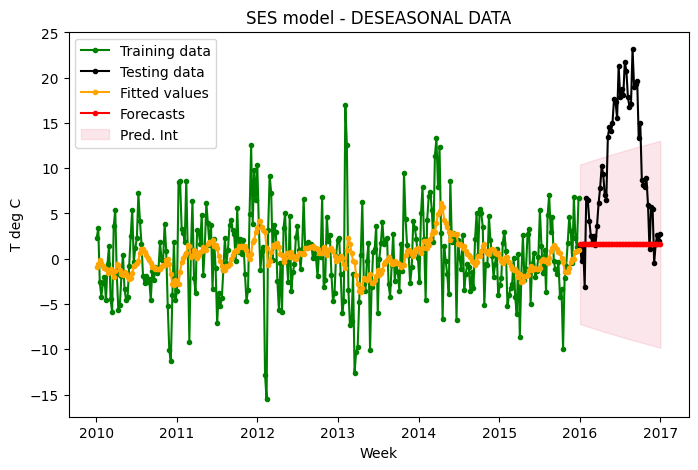

In [11]:
model_des_SES = ETSModel(des_train_t, error = 'add').fit()

# parameters
par_table = {'Param Name': model_des_SES.param_names, 'Values': model_des_SES.params}
par_table = pd.DataFrame(par_table)
display(par_table)

# prediction
pred_model_des_SES=model_des_SES.get_prediction(start=test_t.index[0],end=test_t.index[-1])
# summary
summary_SESmodel_df=pred_model_des_SES.summary_frame()
#forecast
forecast=summary_SESmodel_df['mean']

# PLOT
plt.figure(figsize=(8,5))
plt.plot(des_train_t, color='green',marker = '.',label='Training data')
plt.plot(test_t, color='black', marker = '.',label='Testing data')
plt.plot(model_des_SES.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecast, color='red', marker = '.', label='Forecasts')
plt.fill_between(summary_SESmodel_df.index, summary_SESmodel_df['pi_lower'], summary_SESmodel_df['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('T deg C')
plt.title('SES model - DESEASONAL DATA')
plt.legend()
plt.show()

In [12]:
model_des_SES.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               T (degC)   No. Observations:                  313
Model:                       ETS(ANN)   Log Likelihood                -914.178
Date:                Wed, 29 Jan 2025   AIC                           1834.356
Time:                        15:55:30   BIC                           1845.594
Sample:                    01-03-2010   HQIC                          1838.847
                         - 12-27-2015   Scale                           20.156
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.1147      0.070      1.642      0.101      -0.022       0.252
initial_level      -0.9585      2.094     -0.458      0.647      -5.063       3.146
===================================================================================
Ljung-Box (Q):                       37.61   Jarque-Bera (JB):                25.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.08
Prob(H) (two-sided):                  0.82   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [13]:
# ACCURACY DESEASONAL 

accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'Model':'SES_deseasonal', 'AIC':model_des_SES.aic, 'RMSE':root_mean_squared_error(test_t, summary_SESmodel_df['mean']), 'MAE':mean_absolute_error(test_t, summary_SESmodel_df['mean'])},index=[0])], ignore_index=True)

#### CONCLUSIONI

seeams that the models with the deseasonal data are better than the model with the seasonal one.

## Holt’s linear trend method (**Double Exponential Smoothing**)

The method supports trends that change in different ways: *additive and multiplicative*, depending on whether the trend is linear or exponential, respectively. However, multiplicative trend methods tend to (often) produce poor forecasts, and so are generally not considered.


In this case i decide to not implement this model, because in my opinion does not fit with my data.
Because as i specify below we can use it particularly for modesls in wich we have to model a pronunced trend component.



## Holt-Winters Method (**Triple Exponential Smoothing**)

 Extended Holt’s method to capture seasonality. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations (level, trend and seasonality).

 There are two variations to this method that differ in the nature of the seasonal component. The additive method is preferred when the seasonal variations are roughly constant over time.

 With the additive method, the seasonal component is expressed in absolute terms in the scale of the observed series, and in the level equation the series is seasonally adjusted by subtracting the seasonal component. Within each year, the seasonal component will add up to approximately zero.

 ### For our case seams to be prefirable to aplly the **ADDITIVE ONE** since the seasonal component seams to be constant over time 
 (we have also the possibility to apply the moltiplicative one, but for the structure of the time series seams to be preferible to apply the additive one)

### 1) TES - without consider the trend stabilization 

The trend will be modeled without considering any slowdown or stabilization over time, continuing with constant growth or decrease.

c:\Users\lovoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


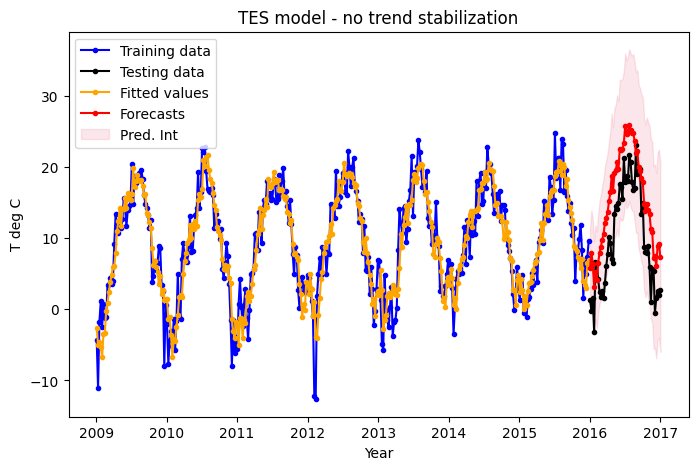

In [14]:
# ADD MODEL - TRIPLE ETS
model_trip_add = ETSModel(train_t, error = 'add', trend='add', seasonal='add',seasonal_periods=52,damped_trend=False).fit()

# Forecasting in the future and prediction interval
pred_trip_add = model_trip_add.get_prediction(start=test_t.index[0], end=test_t.index[-1])
# build the df
summary_pred_trip_add_df = pred_trip_add.summary_frame()
forecast_trip_add = summary_pred_trip_add_df['mean']

# Model parameters
trip_add_tab = {'Param Name': model_trip_add.param_names, 'Values': model_trip_add.params}
trip_add_tab = pd.DataFrame(trip_add_tab)
trip_add_tab

#PLOT
plt.figure(figsize=(8,5))
plt.plot(train_t, color='Blue',marker = '.',label='Training data')
plt.plot(test_t, color='black', marker = '.',label='Testing data')
plt.plot(model_trip_add.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecast_trip_add, color='red', marker = '.', label='Forecasts')
plt.fill_between(summary_pred_trip_add_df .index, summary_pred_trip_add_df ['pi_lower'], summary_pred_trip_add_df ['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Year')
plt.ylabel('T deg C')
plt.legend()
plt.title('TES model - no trend stabilization')
plt.show()

In [15]:
model_trip_add.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               T (degC)   No. Observations:                  365
Model:                       ETS(AAA)   Log Likelihood                -908.291
Date:                Wed, 29 Jan 2025   AIC                           1932.582
Time:                        15:55:32   BIC                           2158.776
Sample:                    01-04-2009   HQIC                          2022.475
                         - 12-27-2015   Scale                            8.491
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2922      0.054      5.415      0.000       0.186       0.398
smoothing_trend      2.922e-05        nan        nan        nan         nan         nan
smoothing_seasonal   7.078e-05        nan        nan        nan         nan         nan
initial_level          -2.6328      2.272     -1.159      0.247      -7.087       1.821
initial_trend           0.0285      0.046      0.621      0.534      -0.061       0.118
initial_seasonal.0     -0.2194      1.141     -0.192      0.847      -2.456       2.017
initial_seasonal.1     -3.0435      1.129     -2.695      0.007      -5.257      -0.830
initial_seasonal.2     -1.6646      1.123     -1.482      0.138      -3.866       0.537
initial_seasonal.3     -1.8297      1.135     -1.612      0.107      -4.054       0.395
initial_seasonal.4      1.7993      1.141      1.577      0.115      -0.437       4.036
initial_seasonal.5      2.2559      1.143      1.974      0.048       0.016       4.496
initial_seasonal.6      4.3547      1.143      3.810      0.000       2.115       6.595
initial_seasonal.7      4.9397      1.143      4.320      0.000       2.699       7.181
initial_seasonal.8      5.7939      1.143      5.067      0.000       3.553       8.035
initial_seasonal.9      4.8864      1.143      4.274      0.000       2.646       7.127
initial_seasonal.10     5.8916      1.139      5.173      0.000       3.659       8.124
initial_seasonal.11     9.0332      1.136      7.954      0.000       6.807      11.259
initial_seasonal.12     9.6057      1.141      8.415      0.000       7.368      11.843
initial_seasonal.13    10.6069      1.142      9.288      0.000       8.369      12.845
initial_seasonal.14    11.1826      1.142      9.790      0.000       8.944      13.421
initial_seasonal.15    13.4732      1.142     11.795      0.000      11.234      15.712
initial_seasonal.16    13.2981      1.141     11.650      0.000      11.061      15.535
initial_seasonal.17    14.9048      1.142     13.052      0.000      12.667      17.143
initial_seasonal.18    16.1738      1.140     14.189      0.000      13.940      18.408
initial_seasonal.19    16.1411      1.141     14.141      0.000      13.904      18.378
initial_seasonal.20    16.5996      1.142     14.542      0.000      14.362      18.837
initial_seasonal.21    17.3338      1.141     15.190      0.000      15.097      19.570
initial_seasonal.22    16.4532      1.136     14.481      0.000      14.226      18.680
initial_seasonal.23    16.0571      1.137     14.122      0.000      13.829      18.286
initial_seasonal.24    17.2617      1.136     15.196      0.000      15.035      19.488
initial_seasonal.25    14.9601      1.139     13.135      0.000      12.728      17.192
initial_seasonal.26    14.0287      1.139     12.314      0.000      11.796      16.262
initial_seasonal.27    13.9325      1.140     12.219      0.000      11.698      16.167
initial_seasonal.28    14.2022      1.139     12.464      0.000      11.9

In [16]:
accuracy_df= pd.concat([accuracy_df, pd.DataFrame({'Model':'TES_trend', 'AIC':model_trip_add.aic, 'RMSE':root_mean_squared_error(test_t, summary_pred_trip_add_df['mean']), 'MAE':mean_absolute_error(test_t, summary_pred_trip_add_df['mean'])},index=[0])], ignore_index=True)

### 1) TES - considering the trend stabilization

The trend will be modeled  considering a slowdown or stabilization over time, continuing with constant growth or decrease.

c:\Users\lovoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


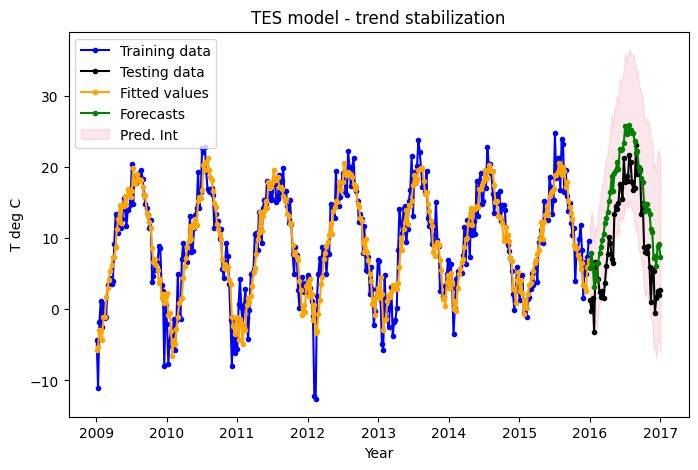

In [17]:
# ADD MODEL - TRIPLE ETS
model_trip_add_t = ETSModel(train_t, error = 'add', trend='add', seasonal='add',seasonal_periods=52,damped_trend=True).fit()

# Forecasting in the future and prediction interval
pred_trip_add_t = model_trip_add_t.get_prediction(start=test_t.index[0], end=test_t.index[-1])
# build the df
summary_pred_trip_add_t_df = pred_trip_add.summary_frame()
forecast_trip_add_t = summary_pred_trip_add_df['mean']

# Model parameters
trip_add_tab_t = {'Param Name': model_trip_add_t.param_names, 'Values': model_trip_add_t.params}
trip_add_tab_t = pd.DataFrame(trip_add_tab)
trip_add_tab_t

#PLOT
plt.figure(figsize=(8,5))
plt.plot(train_t, color='Blue',marker = '.',label='Training data')
plt.plot(test_t, color='black', marker = '.',label='Testing data')
plt.plot(model_trip_add_t.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecast_trip_add_t, color='green', marker = '.', label='Forecasts')
plt.fill_between(summary_pred_trip_add_t_df .index, summary_pred_trip_add_t_df ['pi_lower'], summary_pred_trip_add_t_df ['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Year')
plt.ylabel('T deg C')
plt.legend()
plt.title('TES model - trend stabilization')
plt.show()

In [18]:
model_trip_add.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               T (degC)   No. Observations:                  365
Model:                       ETS(AAA)   Log Likelihood                -908.291
Date:                Wed, 29 Jan 2025   AIC                           1932.582
Time:                        15:55:35   BIC                           2158.776
Sample:                    01-04-2009   HQIC                          2022.475
                         - 12-27-2015   Scale                            8.491
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2922      0.054      5.415      0.000       0.186       0.398
smoothing_trend      2.922e-05        nan        nan        nan         nan         nan
smoothing_seasonal   7.078e-05        nan        nan        nan         nan         nan
initial_level          -2.6328      2.272     -1.159      0.247      -7.087       1.821
initial_trend           0.0285      0.046      0.621      0.534      -0.061       0.118
initial_seasonal.0     -0.2194      1.141     -0.192      0.847      -2.456       2.017
initial_seasonal.1     -3.0435      1.129     -2.695      0.007      -5.257      -0.830
initial_seasonal.2     -1.6646      1.123     -1.482      0.138      -3.866       0.537
initial_seasonal.3     -1.8297      1.135     -1.612      0.107      -4.054       0.395
initial_seasonal.4      1.7993      1.141      1.577      0.115      -0.437       4.036
initial_seasonal.5      2.2559      1.143      1.974      0.048       0.016       4.496
initial_seasonal.6      4.3547      1.143      3.810      0.000       2.115       6.595
initial_seasonal.7      4.9397      1.143      4.320      0.000       2.699       7.181
initial_seasonal.8      5.7939      1.143      5.067      0.000       3.553       8.035
initial_seasonal.9      4.8864      1.143      4.274      0.000       2.646       7.127
initial_seasonal.10     5.8916      1.139      5.173      0.000       3.659       8.124
initial_seasonal.11     9.0332      1.136      7.954      0.000       6.807      11.259
initial_seasonal.12     9.6057      1.141      8.415      0.000       7.368      11.843
initial_seasonal.13    10.6069      1.142      9.288      0.000       8.369      12.845
initial_seasonal.14    11.1826      1.142      9.790      0.000       8.944      13.421
initial_seasonal.15    13.4732      1.142     11.795      0.000      11.234      15.712
initial_seasonal.16    13.2981      1.141     11.650      0.000      11.061      15.535
initial_seasonal.17    14.9048      1.142     13.052      0.000      12.667      17.143
initial_seasonal.18    16.1738      1.140     14.189      0.000      13.940      18.408
initial_seasonal.19    16.1411      1.141     14.141      0.000      13.904      18.378
initial_seasonal.20    16.5996      1.142     14.542      0.000      14.362      18.837
initial_seasonal.21    17.3338      1.141     15.190      0.000      15.097      19.570
initial_seasonal.22    16.4532      1.136     14.481      0.000      14.226      18.680
initial_seasonal.23    16.0571      1.137     14.122      0.000      13.829      18.286
initial_seasonal.24    17.2617      1.136     15.196      0.000      15.035      19.488
initial_seasonal.25    14.9601      1.139     13.135      0.000      12.728      17.192
initial_seasonal.26    14.0287      1.139     12.314      0.000      11.796      16.262
initial_seasonal.27    13.9325      1.140     12.219      0.000      11.698      16.167
initial_seasonal.28    14.2022      1.139     12.464      0.000      11.9

In [19]:
accuracy_df= pd.concat([accuracy_df, pd.DataFrame({'Model':'TES_notrend', 'AIC':model_trip_add_t.aic, 'RMSE':root_mean_squared_error(test_t, summary_pred_trip_add_t_df['mean']), 'MAE':mean_absolute_error(test_t, summary_pred_trip_add_t_df['mean'])},index=[0])], ignore_index=True)

## ACCURACY ETS MODELS - CONCLUSION 

In [20]:
accuracy_df

,Model,AIC,RMSE,MAE
0,SES_seasonal,1945.438950,7.263913,6.306063
1,SES_deseasonal,1834.355550,10.966379,8.640033
2,TES_trend,1932.582440,6.123421,5.627138
3,TES_notrend,1924.839365,6.123421,5.627138


Note: **SES_deseasonal** is not complitly correct, i'll have to add the seasonal component after the forecast.

**CONCLUSION:**

Taking in consideration the note above the best model, as we can expected, are the **TES** the fact that we take in consideration the trend factor does't change a lot the accucary of our model.

____

In [21]:
%store train_t
%store test_t

Stored 'train_t' (Series)
Stored 'test_t' (Series)
